In [87]:
import gzip
import json
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import csv
from html.parser import HTMLParser
from io import StringIO
import re
import pandas as pd
import random
from random import sample
import os.path
import torch
from torch.utils.data import Dataset
from ast import literal_eval
from tqdm.auto import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import copy
from torchmetrics.functional import r2_score
from sklearn.manifold import TSNE

import fasttext
torch.set_printoptions(threshold=10_000)
np.set_printoptions(linewidth=120)
pd.set_option('display.width', 120)

In [61]:
# Prameter counting for debugging: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [3]:
print(f"Is CUDA supported by this system?  {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")
torch_device = torch.device("cuda")
# torch_device = torch.device("cpu")
print(torch_device)

Is CUDA supported by this system?  True
CUDA version: 12.1
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070 SUPER
cuda


In [4]:
class ReviewDataset(Dataset):
    def __init__(self, dataset_fp, tokenize_df=None, mapping_fp=None, rebuild=True):
        print("Reading data...")
        data_raw_df = pd.read_csv(dataset_fp, converters={'review_data': literal_eval})
        data_raw_df.reset_index()
        assert set(data_raw_df.columns) == {'user_id', 'review_data', 'review_count'}

        self.data_product_rating_reviews = dict()
        self.product_mapping = dict()
        self.products = set()

        # Maps strings to index
        self.encoding_mapping = dict()
        self.encoding_vectors = list()

        print("Loading fasttext...")
        self.fmodel = fasttext.load_model('cc.en.300.bin')
        print("Dimension vectors: " + str(self.fmodel.get_dimension()))
        
        self.encoding_vectors.append([0] * self.fmodel.get_dimension())
        # Grab information
        print("Tokenizing data...")
        if rebuild is False and tokenize_df is not None and os.path.exists(tokenize_df):
            print("Attempting to load from filepath...")
            self.data_tokenized_df = pd.read_csv(tokenize_df, converters={'review_tokens': literal_eval, 'review_numtokens': literal_eval, 'review_count': literal_eval})
            if mapping_fp is not None and os.path.exists(mapping_fp):
                print("Loading json into dictionary...")
                with open(mapping_fp, 'r', encoding="utf_8") as fp:
                    self.product_mapping = json.load(fp)
            else:
                self.data_tokenized_df.progress_apply(self._finduniqueprod, axis=1)
        else:
            self.data_tokenized_df = data_raw_df.apply(self._tokenize, axis=1)

            # Product list. Will use embedding to represent the product list.
        product_list = sorted(list(self.products))
        for product_idx in range(len(product_list)):
            product_id = product_list[product_idx]
            self.product_mapping[product_id] = product_idx

    def _finduniqueprod(self, row):
        review_data = row["review_tokens"]
        for review in review_data:
            product_id, product_rating, product_review = review
            self.products.add(product_id)
        return None
        
    def _tokenize(self, row):
        new_row = pd.Series()
        user_id = row["user_id"]
        review_data = row["review_data"]
        review_count = row["review_count"]
               
        tokenized_review_data = []
        tokenized_review_numtokens = []
        for review in review_data:
            product_id, product_rating, product_review = review

            self.products.add(product_id)
            # Collect data on products and their reviews
            if product_id not in self.data_product_rating_reviews.keys():
                self.data_product_rating_reviews[product_id] = []
            self.data_product_rating_reviews[product_id].append((product_rating, product_review))

            # Tokenize the data
            # Split up the data according to fasttext:
            review_tokenized = []
            review_strtokenized = fasttext.tokenize(product_review)
            if len(review_strtokenized) <= 0:
                # Ignore empty reviews.
                print("Empty review found!")
                print(">" + product_review + "<")
                return
            # We limit number of text to 512 values.
            text_counter = 0
            for text in review_strtokenized:
                text_counter += 1
                if text_counter > 512:
                    break
                if text in self.encoding_mapping:
                    review_tokenized.append(self.encoding_mapping[text])
                else:
                    self.encoding_vectors.append(self.fmodel.get_word_vector(text))
                    self.encoding_mapping[text] = len(self.encoding_vectors)-1
                    review_tokenized.append(self.encoding_mapping[text])
                    
            new_tuple = (product_id, product_rating, review_tokenized)
            tokenized_review_data.append(new_tuple)
            tokenized_review_numtokens.append(len(review_tokenized))

        new_row["user_id"] = user_id
        new_row["review_tokens"] = tokenized_review_data
        new_row["review_numtokens"] = tokenized_review_numtokens
        new_row["review_count"] = review_count
        return new_row

    def get_review_count():
        review_count = dict()
        for product_id in self.data_product_rating_reviews.keys():
            review_count[product_id] = len(self.data_product_rating_reviews[product_id])
        return review_count
        
    def __len__(self):
        return len(self.data_tokenized_df)

    def __getitem__(self, idx):
        if isinstance(idx, slice):
            stp = idx.step
            if stp is None:
                stp = 1
            return pd.DataFrame([self.__getitem__(i) for i in range(idx.start, idx.stop, stp)])
        if isinstance(idx, list):
            return pd.DataFrame([self.__getitem__(i) for i in idx])
        data_row = self.data_tokenized_df.iloc[idx]
        return data_row

In [5]:
# Need cased as reference to games occurs.

all_dataset = ReviewDataset("Preprocessing/dataset_operating.csv", "fasttext-tokenized_dataset.csv", "fasttext-tokenized_mapping.json", rebuild=True)
if not os.path.exists("fasttext-tokenized_dataset.csv"):
    all_dataset.data_tokenized_df.to_csv("fasttext-tokenized_dataset.csv", index=False)
if not os.path.exists("fasttext-tokenized_mapping.json"):
    with open("fasttext-tokenized_mapping.json", 'w', encoding="utf_8") as fp:
        json.dump(all_dataset.product_mapping, fp) 

Reading data...
Loading fasttext...
Dimension vectors: 300
Tokenizing data...


In [6]:
def get_collate_fn(pad_index, product_mapping, sample_size=None):
    def collate_fn(batch):
        # Get the max number of tokens IN THE BATCH
        max_batch_tokens = -1
        for bat in batch:
            token_count = max(bat["review_numtokens"])
            max_batch_tokens = max(max_batch_tokens, token_count)
        
        # Given a batch, we modify it via padding and whatnot and randomly sample.
        user_id_list = []
        y_product_id_list = []
        y_product_rating_list = []

        x_product_id_list = [[] for i in range(sample_size-1)]
        x_product_rating_list = [[] for i in range(sample_size-1)]
        x_product_review_list = [[] for i in range(sample_size-1)]
        x_product_numtokens_list = [[] for i in range(sample_size-1)]
        
        for bat in batch:
            # Randomly smaple the sample size if not none
            smple, counts = zip(*random.sample(list(zip(bat["review_tokens"], bat["review_numtokens"])), sample_size))
            smple = list(smple)

            # We have a sample. For the first element we will choose as our target y variable.
            user_id_list.append(bat["user_id"])
            y_product_id_list.append(product_mapping[smple[0][0]])
            y_product_rating_list.append(smple[0][1])

            # For the other samples, we need to collect them. We will have a list of lists storing product id, rating, review.
            # These store everything for the current sample. Should be same size as the sample_size.

            for i in range(1, len(smple)):
                review_sample_idx = i-1 # This is the index in x_product-id_list, etc to store the resulting data
                
                product_id_mapped = product_mapping[smple[i][0]]

                product_rating =  smple[i][1]
                
                token_list = smple[i][2]
                if len(token_list) <= 0:
                    print("ERROR: EMPTY TOKEN LIST!")

                # Padding needs to occur for the batch for one review_sample_idx. For simplicity's sake, we use the entire batch's max token size
                # to determine how much to pad.
                token_padded_np = np.full(max_batch_tokens, pad_index, dtype=int)
                token_padded_np[:counts[i]] = token_list

                # We have ids, ratings, and the reviews for the batch. Now we store this (while distinguishing this!)
                x_product_id_list[review_sample_idx].append(product_id_mapped)
                x_product_rating_list[review_sample_idx].append(product_rating)
                x_product_review_list[review_sample_idx].append(token_padded_np)
                x_product_numtokens_list[review_sample_idx].append(len(token_list))
            
        ret_batch = dict()
        ret_batch["user_ids"] = user_id_list
        ret_batch["batch_size"] = len(y_product_id_list)
        ret_batch["x_size"] = sample_size-1
        ret_batch["y_product_id"] = np.asarray(y_product_id_list, dtype=int)  # The product id of the product whose rating we want to predict. Expected size: batch_size.
        ret_batch["y_product_rating"] = np.asarray(y_product_rating_list, dtype=float) # The rating of the product the person did. Expected size: batch_size.

        ret_batch["x_product_id"] = np.asarray(x_product_id_list, dtype=int) # The product ids. Shape is (sample_size-1, batch_size)
        ret_batch["x_product_rating"] = np.asarray(x_product_rating_list, dtype=float) # The rating numbers. Shape is (sample_size-1, batch_size)
        ret_batch["x_product_review"] = np.asarray(x_product_review_list, dtype=int) # The reviews, padded. Shape is (sample_size-1, batch_size, max_token_length)
        ret_batch["x_product_numtokens"] = np.asarray(x_product_numtokens_list, dtype=int)# The original token length. Shape is (sample_size-1, batch_size)
        
        # batch = {"ids": batch_ids, "length": batch_length, "label": batch_label}
        return ret_batch
    return collate_fn

In [11]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
    
class ReviewNetwork(torch.nn.Module):
    def __init__(self, product_count, torch_device, embed_vocab, dropout=0.5, lstm_hidden=300, lstm_layers=2, review_hiddensize=200, allreview_hiddensize=500, word_embed_size=300, prod_embed_size=200, review_context_size=5, tune=False):
        super().__init__()
        # Setup vocab embed:
        self.torch_device = torch_device
        weight = torch.FloatTensor(np.array(embed_vocab)).to(self.torch_device)
        self.vocab_embedding = torch.nn.Embedding.from_pretrained(weight, freeze=True) # We do not update vocabulary.
        
        # One LSTM, one embedding layer. Applied onto every one. To generate the hidden outputs.
        self.lstm = torch.nn.LSTM(
            word_embed_size,
            lstm_hidden,
            lstm_layers,
            bidirectional=True,
            batch_first=True
        )            

        self.product_embedding = torch.nn.Embedding(num_embeddings=product_count, embedding_dim=prod_embed_size) # Freeze is false, we want to eventaully learn product embeds.

        self.review_context_size = review_context_size

        # Total size for one review: Transformer Output + Product Embed Size + Rating. Intent is to train representation of Review with Product with Rating.
        lstm_embed_concat_size = lstm_hidden*2 + prod_embed_size + 1 
        self.review_rep_fc1 = torch.nn.Linear(in_features=lstm_embed_concat_size, out_features=review_hiddensize)
        self.review_rep_fc2 = torch.nn.Linear(in_features=review_hiddensize, out_features=review_hiddensize)

        # All Five combined dim size plus embed of targt product
        input_total_size = self.review_context_size * review_hiddensize + prod_embed_size

        # Idea: Learn representation of five reviews together.
        self.all_review_fc1 = torch.nn.Linear(in_features=input_total_size, out_features=allreview_hiddensize)
        self.all_review_fc2 = torch.nn.Linear(in_features=allreview_hiddensize, out_features=allreview_hiddensize)

        # Final output(regression)
        self.output_fc = torch.nn.Linear(in_features=allreview_hiddensize, out_features=1)
        
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=dropout)
        
    def forward(self, batch):
        # Batch is already constructed for inputs.
        # Verify that batch's input data is correct.
        batch_size = batch["batch_size"]
        y_product_ids = torch.Tensor(batch['y_product_id']).to(torch.int32).to(self.torch_device)
        y_product_ids = y_product_ids.reshape(y_product_ids.shape[0], 1)
        y_product_embedding = self.product_embedding(y_product_ids).squeeze()

        if batch_size == 1:
            y_product_embedding = torch.unsqueeze(y_product_embedding, 0)

        # print("Y product embedding", y_product_embedding.shape)
        
        module_outputs_list = []
        # Loop through each review
        for review_idx in range(self.review_context_size):
            x_product_ids = torch.Tensor(batch['x_product_id'][review_idx]).to(torch.int32).to(self.torch_device)
            x_product_ids = x_product_ids.reshape(x_product_ids.shape[0], 1)
            x_product_ratings = torch.Tensor(batch['x_product_rating'][review_idx]).to(torch.float32).to(self.torch_device)
            x_product_ratings = x_product_ratings.reshape(x_product_ratings.shape[0], 1)
            x_product_reviews = torch.Tensor(batch['x_product_review'][review_idx]).to(torch.int32).to(self.torch_device)
            x_review_embedding = self.vocab_embedding(x_product_reviews).to(self.torch_device)

            # x_product_numtokens = torch.Tensor(batch['x_product_numtokens'][review_idx]).to(torch.int32).to(self.torch_device) 
            # pad tokens wants num tokens on cpu not gpu
            x_product_numtokens = torch.Tensor(batch['x_product_numtokens'][review_idx]).to(torch.int32)

            # Pack the reviews
            try:
                x_product_reviews_packed = torch.nn.utils.rnn.pack_padded_sequence(x_review_embedding, x_product_numtokens, batch_first=True, enforce_sorted=False)
            except:
                print(batch)
                print("Product reviews", x_product_reviews)
                print("Embedded result", x_review_embedding)
                print("Number of tokens", x_product_numtokens)

            # Apply embeddings to batch of product ids
            x_product_id_embedded = self.product_embedding(x_product_ids).squeeze().to(self.torch_device)
            if batch_size == 1:
                x_product_id_embedded = torch.unsqueeze(x_product_id_embedded, 0)

            # Apply LSTM to batch of reviews
            out, (hidden, cell) = self.lstm(x_product_reviews_packed)
            lstm_output = torch.cat([hidden[-1], hidden[-2]], dim=-1) # bidirectionality

            # print("X review embedding", x_review_embedding.shape)
            # print("X product id embedding", x_product_id_embedded.shape)
            # print("LSTM output shape", lstm_output.shape)
            
            # Concat everything together!
            review_module_input = torch.concat([x_product_id_embedded, lstm_output, x_product_ratings], dim=1)
            # Feed into two NNs.
            fc1_out = self.review_rep_fc1(torch.relu(review_module_input))
            fc2_out = torch.relu(self.review_rep_fc2(self.dropout(torch.relu(fc1_out))))
            module_outputs_list.append(fc2_out)

        # We now concat the module outputs into one mega-layer.        
        module_outputs_list.append(y_product_embedding)
        module_outputs = torch.concat(module_outputs_list, dim=1)

        # Next: Send the data to two more FC layers
        fc1_out = self.all_review_fc1(module_outputs)
        fc2_out = self.all_review_fc2(self.dropout(torch.relu(fc1_out)))

        # Send to single linear output.
        output = self.output_fc(torch.relu(fc2_out))
        return output
# 4 gb of gpu memory needed
model = ReviewNetwork(product_count=len(all_dataset.product_mapping.keys()), embed_vocab=all_dataset.encoding_vectors, torch_device=torch_device).to(torch_device)
loss_func = torch.nn.MSELoss().to(torch_device)
count_parameters(model)

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
|     lstm.weight_ih_l0     |   360000   |
|     lstm.weight_hh_l0     |   360000   |
|      lstm.bias_ih_l0      |    1200    |
|      lstm.bias_hh_l0      |    1200    |
| lstm.weight_ih_l0_reverse |   360000   |
| lstm.weight_hh_l0_reverse |   360000   |
|  lstm.bias_ih_l0_reverse  |    1200    |
|  lstm.bias_hh_l0_reverse  |    1200    |
|     lstm.weight_ih_l1     |   720000   |
|     lstm.weight_hh_l1     |   360000   |
|      lstm.bias_ih_l1      |    1200    |
|      lstm.bias_hh_l1      |    1200    |
| lstm.weight_ih_l1_reverse |   720000   |
| lstm.weight_hh_l1_reverse |   360000   |
|  lstm.bias_ih_l1_reverse  |    1200    |
|  lstm.bias_hh_l1_reverse  |    1200    |
|  product_embedding.weight |  3477600   |
|   review_rep_fc1.weight   |   160200   |
|    review_rep_fc1.bias    |    200     |
|   review_rep_fc2.weight   |   40000    |
|    review

8139301

In [14]:
train_dataset, test_dataset = train_test_split(all_dataset, train_size=0.9, test_size=0.1, random_state=seed, shuffle=True)

train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=32,
    collate_fn=get_collate_fn(0, all_dataset.product_mapping, sample_size=6),
)

test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=4,
    collate_fn=get_collate_fn(0, all_dataset.product_mapping, sample_size=6),
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS = 50
all_train_losses = []
all_train_R2s = []
all_test_losses = []
all_test_R2s = []

best_test_epoch = 0
best_test_loss = 9999
best_test_r2 = -9999
best_test_batch = None

for epoch in range(NUM_EPOCHS):
    print()
    print("Epoch", epoch)
    model.train()
    train_loss_list = []
    test_loss_list = []
    test_r2_list = []
    
    train_pbar =tqdm(train_data_loader)
    list_of_train_predictions = []
    list_of_train_actuals = []
    for train_batch in train_pbar:
        prediction_batch = model.forward(train_batch)
        y_product_ratings = torch.Tensor(train_batch['y_product_rating']).to(torch.float32).to(torch_device)
        y_product_ratings = y_product_ratings.reshape([y_product_ratings.shape[0], 1])
        loss = loss_func(prediction_batch, y_product_ratings) # Also counts as general MSE
        train_loss_list.append(loss)
        train_pbar.set_description("Train Loss %2.6f" % loss.detach().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for i in range(y_product_ratings.shape[0]):
            list_of_train_predictions.append(prediction_batch[i].detach().cpu())
            list_of_train_actuals.append(y_product_ratings[i].detach().cpu())
        
    # avg_train_loss = sum(train_loss_list)/len(train_loss_list)
    
    train_loss = loss_func(torch.tensor(list_of_train_predictions), torch.tensor(list_of_train_actuals)) # Also counts as general MSE
    train_R2 = r2_score(torch.tensor(list_of_train_predictions), torch.tensor(list_of_train_actuals))
    
    print("Train MSE:", train_loss)
    print("Train R2:", train_R2)
    all_train_losses.append(train_loss)
    all_train_R2s.append(train_R2)
    
    model.eval()

    list_of_batches = []
    list_of_test_predictions = []
    list_of_test_actuals = []
    with torch.no_grad():
        for test_batch in tqdm(test_data_loader):
            test_prediction_batch = model.forward(test_batch)
            test_y_product_ratings = torch.Tensor(test_batch['y_product_rating']).to(torch.float32).to(torch_device)
            test_y_product_ratings = test_y_product_ratings.reshape([test_y_product_ratings.shape[0], 1])
    
            list_of_batches.append(test_batch)
            
            for i in range(test_y_product_ratings.shape[0]):
                list_of_test_predictions.append(test_prediction_batch[i].detach().cpu())
                list_of_test_actuals.append(test_y_product_ratings[i].detach().cpu())
    
    test_loss = loss_func(torch.tensor(list_of_test_predictions), torch.tensor(list_of_test_actuals)) # Also counts as general MSE
    test_R2 = r2_score(torch.tensor(list_of_test_predictions), torch.tensor(list_of_test_actuals))

    print("Test MSE:", test_loss)
    print("Test R2:", test_R2)
    if test_R2 > best_test_r2:
        best_test_epoch = epoch
        best_test_loss = test_loss
        best_test_r2 = test_R2
        best_test_batch = copy.deepcopy(list_of_batches)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'mseloss': test_loss,
            'batch_data': best_test_batch
            }, "epoch_" + str(epoch) + "_mseloss_" + str(test_loss) + ".pt")
    all_test_losses.append(test_loss)
    all_test_R2s.append(test_R2)


Epoch 0


Train Loss 2.149660: 100%|███████████████████████████████████████████████████████████| 983/983 [05:20<00:00,  3.07it/s]


Train MSE: tensor(1.5174)
Train R2: tensor(-0.0872)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:47<00:00, 18.43it/s]


Test MSE: tensor(1.5745)
Test R2: tensor(-0.1026)

Epoch 1


Train Loss 1.013358: 100%|███████████████████████████████████████████████████████████| 983/983 [05:36<00:00,  2.92it/s]


Train MSE: tensor(1.3382)
Train R2: tensor(0.0409)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.68it/s]


Test MSE: tensor(2.2235)
Test R2: tensor(-0.6108)

Epoch 2


Train Loss 1.637905: 100%|███████████████████████████████████████████████████████████| 983/983 [05:16<00:00,  3.10it/s]


Train MSE: tensor(1.3085)
Train R2: tensor(0.0572)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.78it/s]


Test MSE: tensor(1.7473)
Test R2: tensor(-0.2754)

Epoch 3


Train Loss 0.865491: 100%|███████████████████████████████████████████████████████████| 983/983 [04:58<00:00,  3.29it/s]


Train MSE: tensor(1.2738)
Train R2: tensor(0.0860)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.98it/s]


Test MSE: tensor(1.5316)
Test R2: tensor(-0.1470)

Epoch 4


Train Loss 1.244262: 100%|███████████████████████████████████████████████████████████| 983/983 [04:53<00:00,  3.35it/s]


Train MSE: tensor(1.2304)
Train R2: tensor(0.1140)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.27it/s]


Test MSE: tensor(2.4719)
Test R2: tensor(-0.8139)

Epoch 5


Train Loss 2.077508: 100%|███████████████████████████████████████████████████████████| 983/983 [04:48<00:00,  3.40it/s]


Train MSE: tensor(1.2266)
Train R2: tensor(0.1238)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.50it/s]


Test MSE: tensor(2.0955)
Test R2: tensor(-0.5506)

Epoch 6


Train Loss 0.723095: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.2061)
Train R2: tensor(0.1381)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.55it/s]


Test MSE: tensor(2.0825)
Test R2: tensor(-0.5126)

Epoch 7


Train Loss 1.595535: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.41it/s]


Train MSE: tensor(1.1572)
Train R2: tensor(0.1555)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.60it/s]


Test MSE: tensor(1.7418)
Test R2: tensor(-0.2795)

Epoch 8


Train Loss 1.755403: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.1728)
Train R2: tensor(0.1592)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.52it/s]


Test MSE: tensor(2.1420)
Test R2: tensor(-0.5385)

Epoch 9


Train Loss 0.739849: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.1583)
Train R2: tensor(0.1700)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.44it/s]


Test MSE: tensor(1.9745)
Test R2: tensor(-0.3838)

Epoch 10


Train Loss 1.242245: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.1572)
Train R2: tensor(0.1751)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.44it/s]


Test MSE: tensor(1.8684)
Test R2: tensor(-0.3601)

Epoch 11


Train Loss 0.978890: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.1239)
Train R2: tensor(0.1915)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.47it/s]


Test MSE: tensor(2.3657)
Test R2: tensor(-0.8419)

Epoch 12


Train Loss 1.045472: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.42it/s]


Train MSE: tensor(1.1183)
Train R2: tensor(0.2001)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.50it/s]


Test MSE: tensor(1.8765)
Test R2: tensor(-0.3274)

Epoch 13


Train Loss 0.851694: 100%|███████████████████████████████████████████████████████████| 983/983 [04:47<00:00,  3.41it/s]


Train MSE: tensor(1.1020)
Train R2: tensor(0.2059)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.34it/s]


Test MSE: tensor(1.6712)
Test R2: tensor(-0.1531)

Epoch 14


Train Loss 1.570523: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.43it/s]


Train MSE: tensor(1.1061)
Train R2: tensor(0.1993)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.58it/s]


Test MSE: tensor(1.9186)
Test R2: tensor(-0.3746)

Epoch 15


Train Loss 0.595975: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.43it/s]


Train MSE: tensor(1.1004)
Train R2: tensor(0.2198)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.52it/s]


Test MSE: tensor(1.5930)
Test R2: tensor(-0.1438)

Epoch 16


Train Loss 1.176939: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.43it/s]


Train MSE: tensor(1.1065)
Train R2: tensor(0.2153)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.42it/s]


Test MSE: tensor(1.8323)
Test R2: tensor(-0.2868)

Epoch 17


Train Loss 0.583962: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.44it/s]


Train MSE: tensor(1.0610)
Train R2: tensor(0.2263)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.39it/s]


Test MSE: tensor(1.8357)
Test R2: tensor(-0.3155)

Epoch 18


Train Loss 0.949460: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.44it/s]


Train MSE: tensor(1.0523)
Train R2: tensor(0.2370)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.56it/s]


Test MSE: tensor(1.8582)
Test R2: tensor(-0.3103)

Epoch 19


Train Loss 0.669737: 100%|███████████████████████████████████████████████████████████| 983/983 [04:46<00:00,  3.43it/s]


Train MSE: tensor(1.0509)
Train R2: tensor(0.2387)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.21it/s]


Test MSE: tensor(1.7278)
Test R2: tensor(-0.2542)

Epoch 20


Train Loss 1.325281: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.97it/s]


Train MSE: tensor(1.0552)
Train R2: tensor(0.2428)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 16.94it/s]


Test MSE: tensor(1.7056)
Test R2: tensor(-0.2252)

Epoch 21


Train Loss 0.671511: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(1.0633)
Train R2: tensor(0.2435)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.11it/s]


Test MSE: tensor(1.8314)
Test R2: tensor(-0.3158)

Epoch 22


Train Loss 0.619788: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.97it/s]


Train MSE: tensor(1.0533)
Train R2: tensor(0.2512)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.07it/s]


Test MSE: tensor(1.5520)
Test R2: tensor(-0.1009)

Epoch 23


Train Loss 1.432147: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(1.0272)
Train R2: tensor(0.2588)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.00it/s]


Test MSE: tensor(1.6637)
Test R2: tensor(-0.2107)

Epoch 24


Train Loss 0.300968: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.97it/s]


Train MSE: tensor(1.0252)
Train R2: tensor(0.2620)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.11it/s]


Test MSE: tensor(1.7066)
Test R2: tensor(-0.2495)

Epoch 25


Train Loss 0.513922: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.97it/s]


Train MSE: tensor(1.0264)
Train R2: tensor(0.2613)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.02it/s]


Test MSE: tensor(1.4925)
Test R2: tensor(-0.0718)

Epoch 26


Train Loss 0.902289: 100%|███████████████████████████████████████████████████████████| 983/983 [05:31<00:00,  2.96it/s]


Train MSE: tensor(1.0321)
Train R2: tensor(0.2590)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.12it/s]


Test MSE: tensor(1.5251)
Test R2: tensor(-0.0964)

Epoch 27


Train Loss 0.549915: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(1.0136)
Train R2: tensor(0.2699)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.00it/s]


Test MSE: tensor(1.5073)
Test R2: tensor(-0.0890)

Epoch 28


Train Loss 1.160944: 100%|███████████████████████████████████████████████████████████| 983/983 [05:29<00:00,  2.98it/s]


Train MSE: tensor(1.0221)
Train R2: tensor(0.2702)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 16.99it/s]


Test MSE: tensor(1.5044)
Test R2: tensor(-0.0985)

Epoch 29


Train Loss 0.505294: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.97it/s]


Train MSE: tensor(1.0012)
Train R2: tensor(0.2760)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 16.96it/s]


Test MSE: tensor(1.5221)
Test R2: tensor(-0.0768)

Epoch 30


Train Loss 0.436549: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(1.0192)
Train R2: tensor(0.2675)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.05it/s]


Test MSE: tensor(1.4748)
Test R2: tensor(-0.0729)

Epoch 31


Train Loss 0.649832: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(0.9990)
Train R2: tensor(0.2851)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.13it/s]


Test MSE: tensor(1.5907)
Test R2: tensor(-0.1726)

Epoch 32


Train Loss 1.100984: 100%|███████████████████████████████████████████████████████████| 983/983 [05:31<00:00,  2.96it/s]


Train MSE: tensor(0.9876)
Train R2: tensor(0.2962)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.03it/s]


Test MSE: tensor(1.6213)
Test R2: tensor(-0.1382)

Epoch 33


Train Loss 0.523126: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(0.9970)
Train R2: tensor(0.2871)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.13it/s]


Test MSE: tensor(1.5611)
Test R2: tensor(-0.1326)

Epoch 34


Train Loss 1.343071: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(0.9866)
Train R2: tensor(0.2942)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.02it/s]


Test MSE: tensor(1.3714)
Test R2: tensor(0.0474)

Epoch 35


Train Loss 0.567358: 100%|███████████████████████████████████████████████████████████| 983/983 [05:30<00:00,  2.98it/s]


Train MSE: tensor(0.9848)
Train R2: tensor(0.2894)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.06it/s]


Test MSE: tensor(1.4151)
Test R2: tensor(-0.0263)

Epoch 36


Train Loss 1.480860: 100%|███████████████████████████████████████████████████████████| 983/983 [05:29<00:00,  2.98it/s]


Train MSE: tensor(0.9962)
Train R2: tensor(0.2928)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:51<00:00, 17.10it/s]


Test MSE: tensor(1.5225)
Test R2: tensor(-0.1017)

Epoch 37


Train Loss 0.481087: 100%|███████████████████████████████████████████████████████████| 983/983 [05:29<00:00,  2.98it/s]


Train MSE: tensor(0.9934)
Train R2: tensor(0.2967)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:49<00:00, 17.77it/s]


Test MSE: tensor(1.5614)
Test R2: tensor(-0.1010)

Epoch 38


Train Loss 0.599646: 100%|███████████████████████████████████████████████████████████| 983/983 [05:06<00:00,  3.21it/s]


Train MSE: tensor(0.9746)
Train R2: tensor(0.3032)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:48<00:00, 17.94it/s]


Test MSE: tensor(1.4662)
Test R2: tensor(-0.0449)

Epoch 39


Train Loss 1.069149: 100%|███████████████████████████████████████████████████████████| 983/983 [05:13<00:00,  3.14it/s]


Train MSE: tensor(0.9729)
Train R2: tensor(0.2998)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.23it/s]


Test MSE: tensor(1.3720)
Test R2: tensor(0.0118)

Epoch 40


Train Loss 1.778944: 100%|███████████████████████████████████████████████████████████| 983/983 [05:16<00:00,  3.11it/s]


Train MSE: tensor(0.9633)
Train R2: tensor(0.3043)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.85it/s]


Test MSE: tensor(1.3258)
Test R2: tensor(0.0484)

Epoch 41


Train Loss 0.494603: 100%|███████████████████████████████████████████████████████████| 983/983 [04:50<00:00,  3.38it/s]


Train MSE: tensor(0.9582)
Train R2: tensor(0.3093)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.36it/s]


Test MSE: tensor(1.3295)
Test R2: tensor(0.0232)

Epoch 42


Train Loss 1.686582: 100%|███████████████████████████████████████████████████████████| 983/983 [04:53<00:00,  3.35it/s]


Train MSE: tensor(0.9662)
Train R2: tensor(0.3043)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.49it/s]


Test MSE: tensor(1.3564)
Test R2: tensor(0.0294)

Epoch 43


Train Loss 0.322111: 100%|███████████████████████████████████████████████████████████| 983/983 [04:57<00:00,  3.31it/s]


Train MSE: tensor(0.9847)
Train R2: tensor(0.3066)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.76it/s]


Test MSE: tensor(1.2677)
Test R2: tensor(0.1079)

Epoch 44


Train Loss 0.271682: 100%|███████████████████████████████████████████████████████████| 983/983 [05:00<00:00,  3.27it/s]


Train MSE: tensor(0.9575)
Train R2: tensor(0.3110)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:47<00:00, 18.48it/s]


Test MSE: tensor(1.2060)
Test R2: tensor(0.1320)

Epoch 45


Train Loss 0.879064: 100%|███████████████████████████████████████████████████████████| 983/983 [05:01<00:00,  3.26it/s]


Train MSE: tensor(0.9726)
Train R2: tensor(0.3152)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:50<00:00, 17.28it/s]


Test MSE: tensor(1.2467)
Test R2: tensor(0.0670)

Epoch 46


Train Loss 1.015214: 100%|███████████████████████████████████████████████████████████| 983/983 [04:49<00:00,  3.40it/s]


Train MSE: tensor(0.9592)
Train R2: tensor(0.3143)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.46it/s]


Test MSE: tensor(1.3709)
Test R2: tensor(0.0384)

Epoch 47


Train Loss 0.572090: 100%|███████████████████████████████████████████████████████████| 983/983 [04:48<00:00,  3.41it/s]


Train MSE: tensor(0.9511)
Train R2: tensor(0.3156)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.56it/s]


Test MSE: tensor(1.3374)
Test R2: tensor(0.0421)

Epoch 48


Train Loss 0.535101: 100%|███████████████████████████████████████████████████████████| 983/983 [04:56<00:00,  3.32it/s]


Train MSE: tensor(0.9429)
Train R2: tensor(0.3206)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.50it/s]


Test MSE: tensor(1.1927)
Test R2: tensor(0.1273)

Epoch 49


Train Loss 0.459296: 100%|███████████████████████████████████████████████████████████| 983/983 [04:56<00:00,  3.32it/s]


Train MSE: tensor(0.9381)
Train R2: tensor(0.3277)


100%|████████████████████████████████████████████████████████████████████████████████| 874/874 [00:45<00:00, 19.21it/s]

Test MSE: tensor(1.2827)
Test R2: tensor(0.0470)


In [22]:
# Plot the graph of MSE over time
epoch_range = np.arange(1, 51)
train_losses_np = np.array(all_train_losses)
train_r2_np = np.array(all_train_R2s)
test_losses_np = np.array(all_test_losses)
test_r2_np = np.array(all_test_R2s)

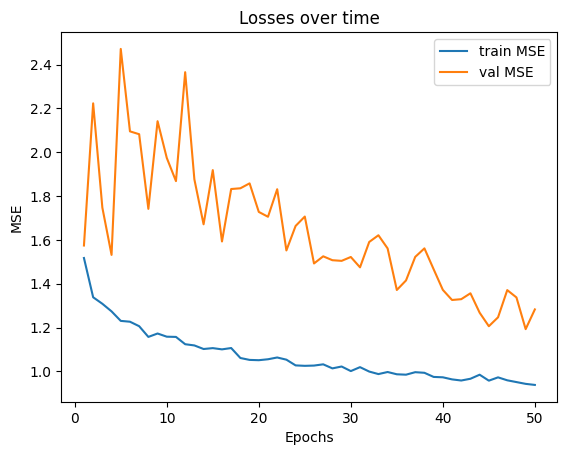

In [33]:
plt.plot(epoch_range, train_losses_np, label='train MSE')
plt.plot(epoch_range, test_losses_np, label='val MSE')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Losses over time")
plt.show()

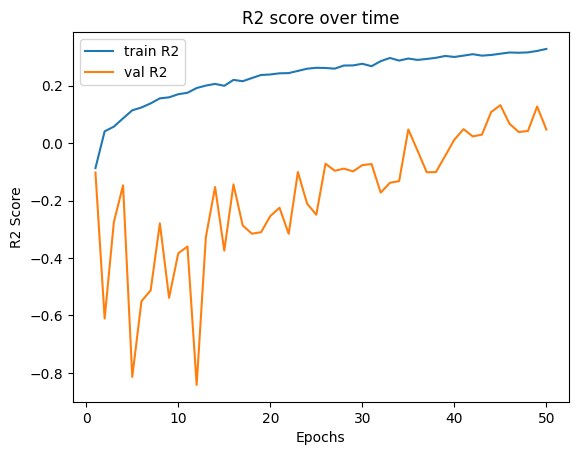

In [34]:
plt.plot(epoch_range, train_r2_np, label='train R2')
plt.plot(epoch_range, test_r2_np, label='val R2')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("R2 Score")
plt.title("R2 score over time")
plt.show()

In [58]:
def print_batch_details(batch_data, product_mapping):
    data_info = []
    for minibatch in batch_data:
        user_ids = minibatch["user_ids"]
        product_ids = minibatch["y_product_id"]
        product_ratings = minibatch["y_product_rating"]
        product_label = []
        for pid in product_ids:
            product_label.append(product_mapping[pid])
        data_df = pd.DataFrame()
        data_df["user_id"] = user_ids
        data_df["product_id"] = product_label
        data_df["rating"] = product_ratings
        data_info.append(data_df)
    cc = pd.concat(data_info)
    cc.reset_index(drop=True, inplace=True)
    return cc

In [60]:
assert len(all_dataset.product_mapping.values()) == len(set(all_dataset.product_mapping.values()))
inverted_map = dict((v, k) for k, v in all_dataset.product_mapping.items())
testbatch_used = print_batch_details(best_test_batch, inverted_map)
testbatch_used.to_csv("Testbatch.csv", index=None)

In [88]:
# Visualize the product embeddings learned over time
embeds = model.product_embedding.weight.detach().cpu().numpy().copy() # extract embedding layer
tsne = TSNE(n_components=2, perplexity=5, random_state=seed, init='random', learning_rate=200)
fitted_dims = tsne.fit_transform(embeds)

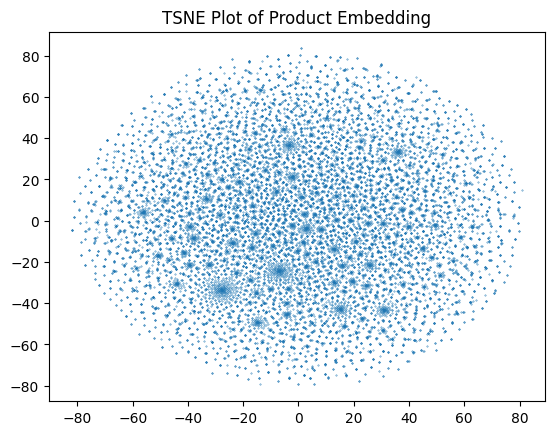

In [89]:
x_dim, y_dim = fitted_dims.T
plt.scatter(x_dim, y_dim, s=0.1)
plt.title("TSNE Plot of Product Embedding")
plt.show()